# CLASSIFICATION WITH NAIVE BAYES CLASSIFIER

by ChunkDevs (Group 1)

One of the models that have been chosen for our project baseline is **Naive Bayes classifier**, a generative classifier which builds a model of how a class could generate some input data. This classifier makes a strong simplifying (naive) assumption called Naive Bayes assumption, which assumes the conditional independence between the features. This kind of model can work extremely well ) on very small datasets or short documents. Furthermore, naive Bayes is easy to implement and very fast to train, since there’s no optimization step into this model learning process. 

In order to transform the tweets in a input data that is compatible with this model, we will try two different feature extraction techniques: **Bag Of Words** (**BOW**) and **Term Frequency - Inverse Document Frequency** (**TF-IDF**). We will use `CountVectorizer` and `TfidfVectorizer` classes from `sklearn.feature_extraction.text `.

We will try BOW and TF-IDF for both binary and multiclass classification task, therefore, we will use the class `ChunkDevs_GridTrainer` of our library to select the best hyperparameteres with the gridsearch with cross-validation, validate our model and finally predict on the raw unprocessed tweets of the test set.

In [1]:
import sys
import os

directory = os.getcwd().split(os.path.sep)
root_index = directory.index("V_HLT")
root_path = os.path.sep.join(directory[:root_index+1])

sys.path.append(root_path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from _chunkdevs.models import ChunkDevs_GridTrainer, ModelHandler
from _chunkdevs.data_functions import *

from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB, BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

2024-06-24 18:05:02.326055: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 18:05:02.527405: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 18:05:05.992669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# DATA LOADING

In [3]:
dev_path = os.path.join(root_path, "data", "processed", "english_tweets_dev_set.csv")
dev = pd.read_csv(dev_path, encoding="utf-8", skipinitialspace=True)

test_path = os.path.join(root_path, "data", "processed", "english_tweets_test_set.csv")
test = pd.read_csv(test_path, encoding="utf-8", skipinitialspace=True)

In [4]:
dev.shape, test.shape

((26268, 5), (2922, 4))

In [5]:
dev.head()

,tweet_text,cyberbullying_type,cyberbullying_type_bin,cyberbullying_type_multi,tweet_text_cleaned
0,I was bullied in fourth grade cause my twin li...,age,1,0,i was bullied in fourth grade cause my twin li...
1,I bullied myself for not looking like the othe...,age,1,0,i bullied myself for not looking like the othe...
2,Hijabi lives in a diverse community and joins ...,age,1,0,hijabi lives in a diverse community and joins ...
3,Your amazing me and my son who’s 11 and a aspi...,age,1,0,your amazing me and my son whos 11 and a aspir...
4,I hope all the bitches who bullied girls in hi...,age,1,0,i hope all the bitches who bullied girls in hi...


In [6]:
test.head()

,tweet_text,cyberbullying_type,cyberbullying_type_bin,cyberbullying_type_multi
0,"Concept of 'Dark Power': Like soft power, but ...",age,1,0
1,I want to cyber bully a school board member,age,1,0
2,my school was super chill about it.... unlike ...,age,1,0
3,If that person is a school yard bully won't th...,age,1,0
4,I can't stand his voice or his look. He's a sm...,age,1,0


In [7]:
path_models = os.path.join(root_path, 'outputs', 'models')

RANDOM_STATE = 42

k_fold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

<div style="font-size: 16px;">
    
Using the same `RANDOM_STATE` value as the other notebook. For the crossvalidation approach, we decided to split the dev-set into 5 folds and shuffling the examples for each iteration during the gridsearch of the models.    

<br>
</div>

# FEATURES EXTRACTION WITH COUNTVECTORIZER

<div style="font-size: 16px;">
    
We've istantiated a **Bernoulli Naive Bayes** model to classify cyberbullying tweets using a Bag of Words (BoW) representation. This model has been chosen for this kind of technique because it is particularly well-suited for binary features, making it a good fit for text data that is vectorized into binary counts, as it assumes binary-valued features.

</div>

## BINARY CLASSIFICATION TASK

<div style="font-size: 16px;">

Initially, a `BernoulliNB model` and a `CountVectorizer` are instantiated to convert text data into binary vectors. We extracts the cleaned tweet texts and their corresponding binary labels for both the development and test datasets. We then fit the `CountVectorizer` to the development dataset and transforms both the development and test datasets into binary vector forms. A parameter grid is defined for hyperparameter tuning, specifying various values for `alpha`, `fit_prior` and `binarize` to find the optimal model configuration during cross-validation.

</div>

In [8]:
model = BernoulliNB()
vectorizer = CountVectorizer()


X_dev_bin = dev['tweet_text_cleaned'].values
y_dev_bin = dev['cyberbullying_type_bin'].values
X_test_bin = test['tweet_text'].values
y_test_bin = test['cyberbullying_type_bin'].values

X_dev_bin = vectorizer.fit_transform(X_dev_bin)
X_test_bin = vectorizer.transform(X_test_bin)


param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False],
    'binarize': [0.0, 0.5, 1.0]
}

For the model implementation, we used our class `ChunkDevs_GridTrainer` for training different models using Grid Search with cross-validation.


This are the **attributes** needed for our class:

- `model` : The model to be optimized. (Compatible with NB, LogReg, SVM, and XGB)
- `param_grid` : The model parameter grid to search over.
- `scoring` : The scoring metric to use for evaluation, in all the notebook we used **f1 score for binary** tasks and **accuracy for multiclass** 
- `cv` : The cross-validation strategy (5 folds with shuffling have been used for every model (except for LSTM and transformers )in order to maintain the same procedure)
- `n_jobs` : The number of jobs to run in parallel. (always -1 for enabling parallel use of the processors)
- `grid_search` : The GridSearchCV object after fitting.

This are the **methods** available with our class:

- `train`: Train the model using Grid Search with the provided training data.
- `predict` Make blind predictions using the trained model.
- `get_best_params`Get the best parameters found by Grid Search.
- `get_best_score` Get the best score achieved by Grid Search.
- `get_classification_report` Get the classification report for the test data.
- `get_confusion_matrix` Get the confusion matrix for the test data.
- `save_results` Save the Grid Search results and classification report to a file.

### GRIDSEARCH AND TRAINING

Gridsearch with 5-fold cross-validation and shuffling enabled. After finding the best hyperparameters, we train the model using all the dev-set

For the binary task, the `ChunkDevs_GridTrainer` is initialized with "f1_weighted" as scoring because the dataset has an imbalanced class distribution, with the "not cyberbullying" class being less numerous than the "cyberbullying" class. In such cases, accuracy  can be misleading since a model could achieve high accuracy by simply predicting the majority class.

In [9]:
# binary classification
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="f1_weighted", cv=k_fold, n_jobs=-1)
best_model_bernoulli_countvect_bin = trainer.train(X_dev_bin, y_dev_bin)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

Best Parameters: {'alpha': 1.0, 'binarize': 0.0, 'fit_prior': True} 



### TESTING PHASE

Testing of the assessed model to the test-set and showing our results

In [10]:
y_pred_bin = trainer.predict(X_test_bin)
print(f"Classification report for {str(trainer.model)}/n ")
report = trainer.get_classification_report(X_test_bin, y_test_bin)
print(report)

Classification report for BernoulliNB()
              precision    recall  f1-score   support

           0       0.55      0.50      0.53       487
           1       0.90      0.92      0.91      2435

    accuracy                           0.85      2922
   macro avg       0.73      0.71      0.72      2922
weighted avg       0.84      0.85      0.85      2922



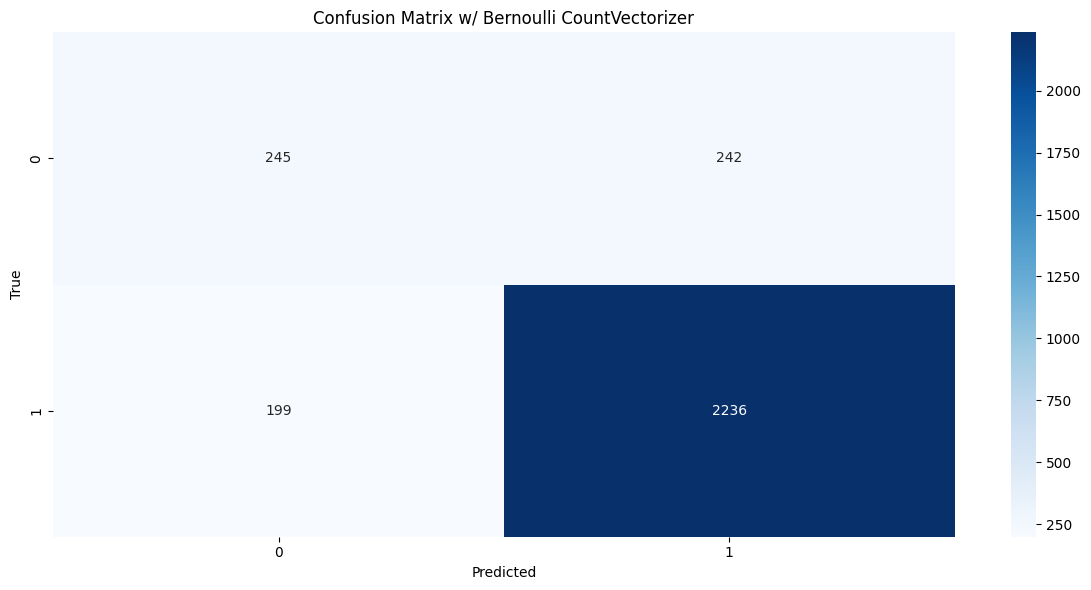

In [11]:
matrix = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ Bernoulli CountVectorizer')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', 'NB_binary_BOW_CM.png'))
plt.show()

### RESULTS SAVING
Saving the results to the appropriate folder

In [12]:
save_path = os.path.join(root_path, 'outputs', 'reports', 'NB_binary_BOW.txt')
trainer.save_results(X_test_bin, y_test_bin, save_path)

Report saved to /home/m.sanna21/V_HLT/outputs/reports/NB_binary_BOW.txt


## MULTICLASS CLASSIFICATION TASK

In [13]:
model = BernoulliNB()

X_dev_multi = dev['tweet_text_cleaned'].values
y_dev_multi = dev['cyberbullying_type_multi'].values
X_test_multi = test['tweet_text'].values
y_test_multi = test['cyberbullying_type_multi'].values

X_dev_multi = vectorizer.fit_transform(X_dev_multi)
X_test_multi = vectorizer.transform(X_test_multi)


param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False],
    'binarize': [0.0, 0.5, 1.0]
}

### GRIDSEARCH AND TRAINING

Gridsearch with 5-fold cross-validation and shuffling enabled. After finding the best hyperparameters, we train the model using all the dev-set

In [14]:
# classification for multiclass task
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="accuracy", cv=k_fold, n_jobs=-1)
best_model_bernoulli_countvect_multi = trainer.train(X_dev_multi, y_dev_multi)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

Best Parameters: {'alpha': 0.5, 'binarize': 0.0, 'fit_prior': True} 



### TESTING PHASE

Testing of the assessed model to the test-set and showing our results

In [15]:
y_pred_multi = trainer.predict(X_test_multi)
print(f"Classification report for {str(trainer.model)}")
report = trainer.get_classification_report(X_test_multi, y_test_multi)
print(report)

Classification report for BernoulliNB()
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       487
           1       0.95      0.93      0.94       487
           2       0.90      0.73      0.81       487
           3       0.54      0.62      0.57       487
           4       0.60      0.70      0.64       487
           5       0.94      0.88      0.91       487

    accuracy                           0.79      2922
   macro avg       0.81      0.79      0.80      2922
weighted avg       0.81      0.79      0.80      2922



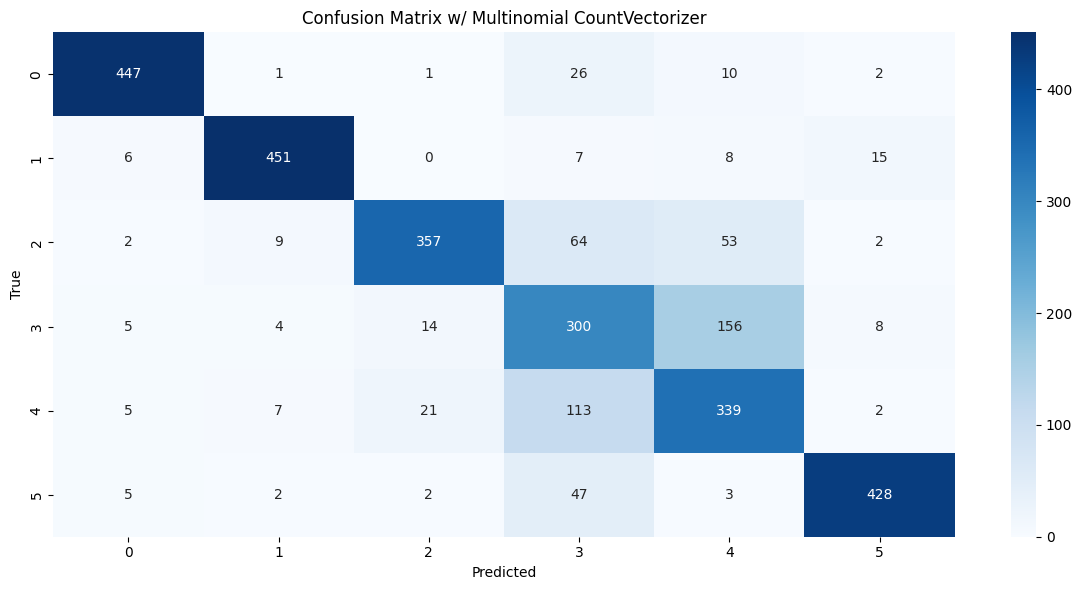

In [16]:
matrix = confusion_matrix(y_test_multi, y_pred_multi)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ Multinomial CountVectorizer')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', 'NB_multiclass_BOW_CM.png'))
plt.show()

### RESULTS SAVING
Saving the results to the appropriate folder

In [17]:
save_path = os.path.join(root_path, 'outputs', 'reports', 'NB_multiclass_BOW.txt')
trainer.save_results(X_test_multi, y_test_multi, save_path)

Report saved to /home/m.sanna21/V_HLT/outputs/reports/NB_multiclass_BOW.txt


# FEATURES EXTRACTION WITH TF-IDF

We've instantiated a **Multinomial Naive Bayes** model to classify cyberbullying tweets using a TF-IDF representation. This model have been chosen for this technique because it is particularly well-suited for features that represent frequency counts or probabilities, making it a good fit for text data that is transformed into term frequency-inverse document frequency (TF-IDF) vectors.

## BINARY CLASSIFICATION TASK

Initially, a `MultinomialNB` model and a `TfidfVectorizer` are instantiated to convert text data into TF-IDF vectors. We extract the cleaned tweet texts and their corresponding binary labels for both the development and test datasets. We then fit the `TfidfVectorizer` to the development dataset and transform both the development and test datasets into TF-IDF vector forms. 

A parameter grid is defined for hyperparameter tuning, specifying various values for `alpha`, `fit_prior` and `binarize` to find the optimal model configuration during cross-validation.

For the training and the testing phase, we repeat the same procedure as before

In [18]:
model = MultinomialNB()
vectorizer = TfidfVectorizer()


X_dev_bin = dev['tweet_text_cleaned'].values
y_dev_bin = dev['cyberbullying_type_bin'].values
X_test_bin = test['tweet_text'].values
y_test_bin = test['cyberbullying_type_bin'].values

X_dev_bin = vectorizer.fit_transform(X_dev_bin)
X_test_bin = vectorizer.transform(X_test_bin)


param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

### GRIDSEARCH AND TRAINING

In [19]:
# binary classification
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="f1_weighted", cv=k_fold, n_jobs=-1)
best_model_multinomial_tfidf_bin = trainer.train(X_dev_bin, y_dev_bin)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

Best Parameters: {'alpha': 0.5, 'fit_prior': False} 



### TESTING PHASE

In [20]:
y_pred_bin = trainer.predict(X_test_bin)
print(f"Classification report for {str(trainer.model)}")
report = trainer.get_classification_report(X_test_bin, y_test_bin)
print(report)

Classification report for MultinomialNB()
              precision    recall  f1-score   support

           0       0.59      0.38      0.46       487
           1       0.88      0.95      0.92      2435

    accuracy                           0.85      2922
   macro avg       0.74      0.66      0.69      2922
weighted avg       0.84      0.85      0.84      2922



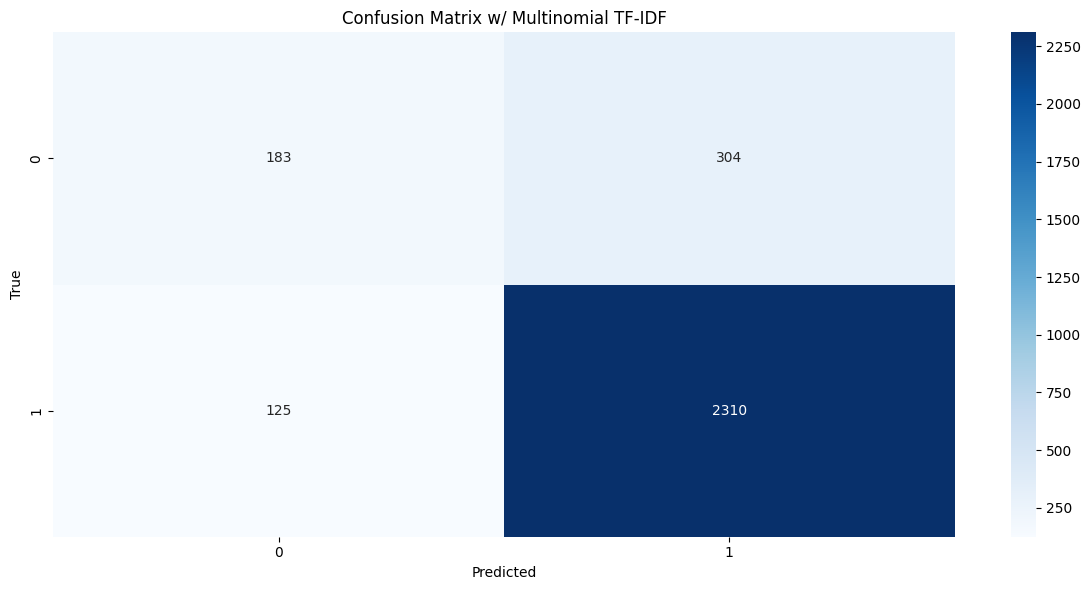

In [21]:
matrix = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ Multinomial TF-IDF')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', 'NB_binary_tfidf_CM.png'))
plt.show()

### RESULTS SAVING
Saving the results to the appropriate folder

In [22]:
save_path = os.path.join(root_path, 'outputs', 'reports', 'NB_binary_tfidf.txt')
trainer.save_results(X_test_bin, y_test_bin, save_path)

Report saved to /home/m.sanna21/V_HLT/outputs/reports/NB_binary_tfidf.txt


## MULTICLASS CLASSIFICATION TASK

In [23]:
model = MultinomialNB()

X_dev_multi = dev['tweet_text_cleaned'].values
y_dev_multi = dev['cyberbullying_type_multi'].values
X_test_multi = test['tweet_text'].values
y_test_multi = test['cyberbullying_type_multi'].values

X_train_multi = vectorizer.fit_transform(X_dev_multi)
X_test_multi = vectorizer.transform(X_test_multi)


param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

### GRIDSEARCH AND TRAINING

In [24]:
# classification for multiclass task
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="accuracy", cv=k_fold, n_jobs=-1)
best_model_multinomial_tfidf_multi = trainer.train(X_train_multi, y_dev_multi)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

Best Parameters: {'alpha': 0.1, 'fit_prior': False} 



### TESTING PHASE

In [25]:
y_pred_multi = trainer.predict(X_test_multi)
print(f"Classification report for {str(trainer.model)}")
report = trainer.get_classification_report(X_test_multi, y_test_multi)
print(report)

Classification report for MultinomialNB()
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       487
           1       0.84      0.91      0.87       487
           2       0.80      0.78      0.79       487
           3       0.60      0.45      0.51       487
           4       0.61      0.52      0.56       487
           5       0.82      0.93      0.87       487

    accuracy                           0.75      2922
   macro avg       0.74      0.75      0.74      2922
weighted avg       0.74      0.75      0.74      2922



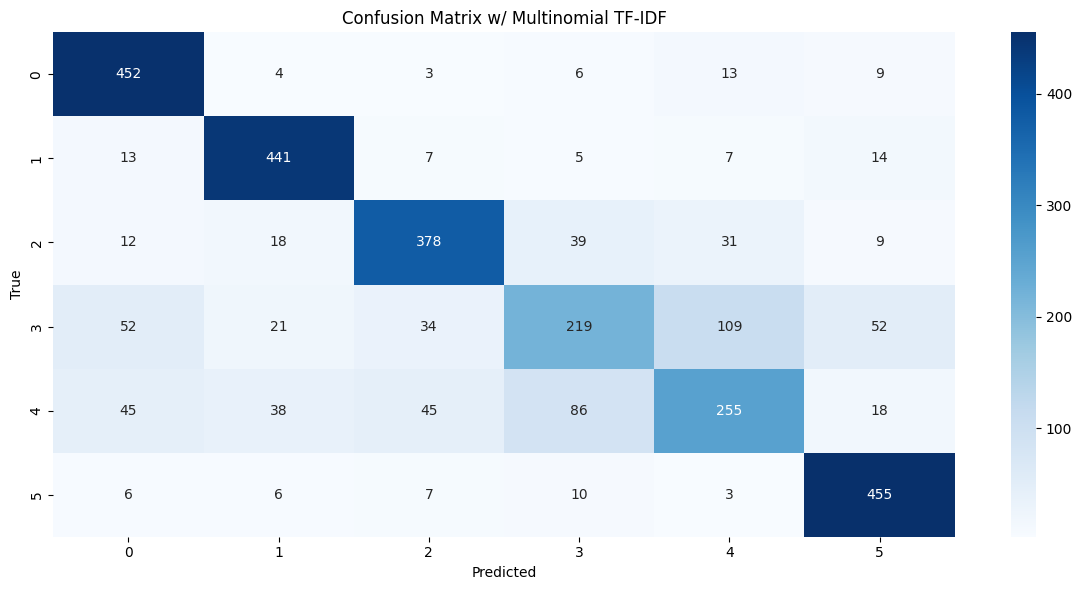

In [26]:
matrix = confusion_matrix(y_test_multi, y_pred_multi)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ Multinomial TF-IDF')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', 'NB_multiclass_tfidf_CM.png'))
plt.show()

### RESULTS SAVING
Saving the results to the appropriate folder

In [27]:
save_path = os.path.join(root_path, 'outputs', 'reports', 'NB_multiclass_tfidf.txt')
trainer.save_results(X_test_multi, y_test_multi, save_path)

Report saved to /home/m.sanna21/V_HLT/outputs/reports/NB_multiclass_tfidf.txt


# MODELS SAVING

Saving the final models to the appropriate folder

In [28]:
handler = ModelHandler(path_models)


models = {
    "BNB_BOW_binary" : best_model_bernoulli_countvect_bin,
    "BNB_BOW_multiclass" : best_model_bernoulli_countvect_multi,
    "MNB_TFIDF_binary" : best_model_multinomial_tfidf_bin,
    "MNB_TFIDF_multiclass" : best_model_multinomial_tfidf_multi
}

handler.save_models(models)

------------------------------------------------------------------------------------------
| Save model 'BNB_BOW_binary' to /home/m.sanna21/V_HLT/outputs/models/BNB_BOW_binary.pkl |
------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
| Save model 'BNB_BOW_multiclass' to /home/m.sanna21/V_HLT/outputs/models/BNB_BOW_multiclass.pkl |
--------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
| Save model 'MNB_TFIDF_binary' to /home/m.sanna21/V_HLT/outputs/models/MNB_TFIDF_binary.pkl |
----------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
| Save model 'MNB_TFIDF_multiclass' to /ho

<div style="font-size: 22px;">   

Our baseline exhibit different strengths in identifying cyberbullying and not cyberbullying tweets. Firstly, in the
binary task the Bernoulli Naive Bayes model with Bag-of-Words achieves 56% precision for non-cyberbullying (0)
and 90% for cyberbullying (1), with a similar pattern in recall and F1-score. Meanwhile, the Multinomial Naive
Bayes with TF-IDF scores higher in precision for non-cyberbullying (60%) but lower in recall, emphasizing its
strengths and weaknesses in differentiating cyberbullying.

Moving to to the multiclass task, we have seen strong performances from these models. Bernoulli Naive Bayes with BOW and Multinomial Naive Bayes with TF-IDF achieve accuracies of 79% and 75%, respectively.

Naive Bayes is a **very good multiclass baseline** for our task, but it has been **slightly surpassed by logistic regression**

<br></div>
